### Simple GAN 

_Version 5: Tuning model layers_

In [1]:
#!pip install nibabel
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [3]:
df

,FILE_ID,DX_GROUP,DSM_IV_TR,SEX,DX_Control,DX_DSM,SEX_,PATH
0,Pitt_0050005,1,1,2,Autism,Autism,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
1,Pitt_0050006,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
2,Pitt_0050007,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
3,Pitt_0050011,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
4,Pitt_0050014,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
...,...,...,...,...,...,...,...,...
386,UCLA_1_0051280,2,0,1,Control,Control,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
387,UCLA_1_0051281,2,0,1,Control,Control,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
388,UCLA_1_0051282,2,0,2,Control,Control,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
389,UCLA_2_0051303,2,0,2,Control,Control,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...


In [4]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
#images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

# positive cases only
#images_paths = images_paths_f_case + images_paths_m_case

# female only (testing purposes)
#images_paths = images_paths_f_case

# male only (testing purposes)
images_paths = images_paths_m_case

# female controls 
#images_paths = images_paths_f_control

num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [5]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [6]:
image_array.shape

(124, 61, 73, 61)

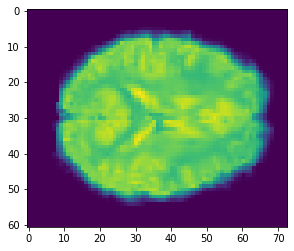

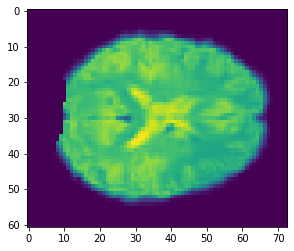

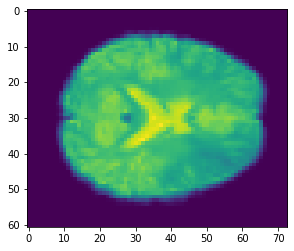

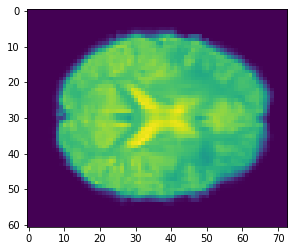

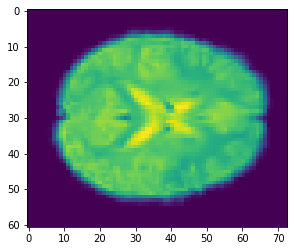

In [7]:
# Visualize 5 of the 391 images
for i in image_array[:5]: 
    plt.imshow(i[:,:,30])
    plt.show()

In [8]:
# #??? Ask Chelsea about this line of code. How is this phenotype data? 
# pheno = df[['FILE_ID', 'DX_GROUP']]
# pheno_array = np.array(pheno['DX_GROUP'])
# pheno_array = np.where(pheno_array == 2, 0, pheno_array) # This is a function to replace 2 with 0
# # distribution
# df['DX_GROUP'].value_counts()

# I think she means for this to be y label data right?
y = df[['FILE_ID', 'DSM_IV_TR', 'SEX_']] # 1 means Autism, 0 means Control
#y_array = np.array(y['DSM_IV_TR'])

#positive only 
#y_array = np.array(y.query("DSM_IV_TR == 1")["DSM_IV_TR"])

# female only (testing purposes)
#y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Female'")["DSM_IV_TR"])

# male only (testing purposes)
y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Male'")["DSM_IV_TR"])

# female controls 
#y_array = np.array(y.query("DSM_IV_TR == 0 & SEX_ == 'Female'")["DSM_IV_TR"])

In [9]:
y_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(image_array, pheno_array, test_size = 0.25, random_state = 44)
x_train, x_test, y_train, y_test = train_test_split(image_array, y_array, test_size = 0.25, random_state = 44)

In [11]:
x_train.shape

(93, 61, 73, 61)

In [12]:
# Checking imbalance of training set. Below is how you do value counts for np array. 
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 1, 93]])

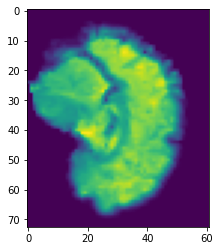

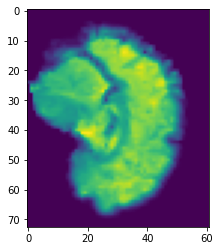

In [13]:
# first attempt at plotting 
#plt.imshow(x_train[:,:,30])
#TypeError: Invalid shape (293, 61, 61) for image data

#borrowing my other code for plotting
for i in x_train[:1]: 
    plt.imshow(i[30,:,:])
    plt.show()
    
# this code also works
plt.imshow(x_train[0][30])
plt.show()

In [14]:
# def train_preprocessing(volume, label):
#     """Process training data by rotating and adding a channel."""
#     # Rotate volume
#     volume = rotate(volume)
#     volume = tf.expand_dims(volume, axis=3) #??? Is the extra channel by how much the image was rotated? Ask Dylan.
#     return volume, label

# def validation_preprocessing(volume, label):
#     """Process validation data by only adding a channel."""
#     volume = tf.expand_dims(volume, axis=3)
#     return volume, label

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1 #return the integer of the division 
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image[30,:,:])
        #plt.imshow(image, cmap="binary")
        plt.axis("off")

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # This is cool, double-check the documentation for this??? 
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)) #??? Should we have equal number of each class in our training data? 

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train)) # ??? shuffle dubplicates right? Or does it only shuffle? Double-check
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE) # ??? I thought prefetch was for speed purposes. What is this tf.data.AUTOTUNE. Double-check. 
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-03 17:45:58.530590: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-03 17:45:58.530637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-aw34-14c1): /proc/driver/nvidia/version does not exist
2022-05-03 17:45:58.533503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GAN

Cross section 30

In [16]:
#codings_size = 30 # What is this???
codings_size = 1000 # What is this???
# Apparently, latent representations = coding 
# !!! Let's iterate through values of this to tst what effect it has 
generator = keras.models.Sequential([
    keras.layers.Dense(3000, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(5000, activation="selu"),
    keras.layers.Dense(61 * 73 * 61, activation="sigmoid"),
    keras.layers.Reshape([61, 73, 61])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[61, 73, 61]),
    keras.layers.Dense(5000, activation="selu"),
    keras.layers.Dense(3000, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [17]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
batch_size = 32
#batch_size = 1 # Never finishes 
#batch_size = 150 # Errors out 
#x_train = tf.cast(x_train,tf.float32) # This was not in the texbook code. Test the effect of this 
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
## Loss function 
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # compares the discriminator's predictions on real images to an array of 1s (class 1 - real)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # compares the discriminator's predictions on fake (generated) images to an array of 0s (class 0 - fake)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # if the generator is performing well, the discriminator will classify the fake images as real (or 1)
    # therefore, compare the discriminators decisions on the generated images to an array of 1s
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
#@tf.function

gen_loss_list = []
disc_loss_list = []

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #print(noise)
            generated_images = generator(noise, training=True)
            
            ## loss section 
            real_output = discriminator(X_batch, training=True)
            # Classify fake images using discriminator
            fake_output = discriminator(generated_images,training=True)
            # Calculate the loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            
            #print(gen_loss)
            #print(disc_loss)
            
            gen_loss_list.append(gen_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())
    
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #print(X_fake_and_real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            #print(y1)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1) #??? How does train_on_batch differ from fit? 
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8) # not shown 
        #plot_multiple_images(generated_images, 4) # not shown 
        #plt.show() # not shown
        if epoch == 0: 
            plot_multiple_images(generated_images, 8) # not shown 
            plt.show() # not shown
        elif (epoch+1)%50 == 0: 
            plot_multiple_images(generated_images, 8) # not shown 
            plt.show() # not shown
    #return generated_images # Not shown. Trying to figure out where to put this 

Epoch 1/500


/usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


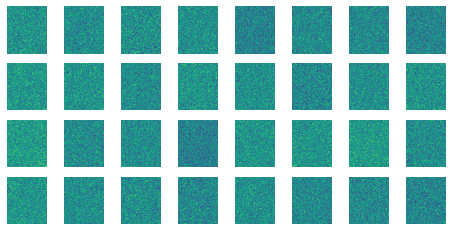

Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500


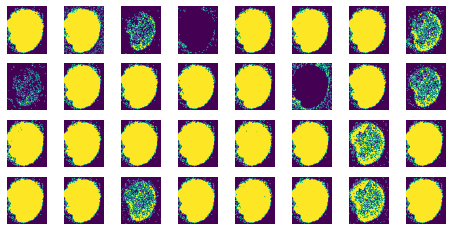

Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78/500
Epoch 79/500
Epoch 80/500
Epoch 81/500
Epoch 82/500
Epoch 83/500
Epoch 84/500
Epoch 85/500
Epoch 86/500
Epoch 87/500
Epoch 88/500
Epoch 89/500
Epoch 90/500
Epoch 91/500
Epoch 92/500
Epoch 93/500
Epoch 94/500
Epoch 95/500
Epoch 96/500
Epoch 97/500
Epoch 98/500
Epoch 99/500
Epoch 100/500


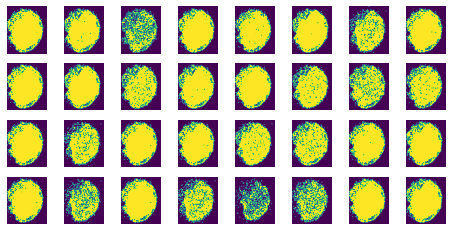

Epoch 101/500
Epoch 102/500
Epoch 103/500
Epoch 104/500
Epoch 105/500
Epoch 106/500
Epoch 107/500
Epoch 108/500
Epoch 109/500
Epoch 110/500
Epoch 111/500
Epoch 112/500
Epoch 113/500
Epoch 114/500
Epoch 115/500
Epoch 116/500
Epoch 117/500
Epoch 118/500
Epoch 119/500
Epoch 120/500
Epoch 121/500
Epoch 122/500
Epoch 123/500
Epoch 124/500
Epoch 125/500
Epoch 126/500
Epoch 127/500
Epoch 128/500
Epoch 129/500
Epoch 130/500
Epoch 131/500
Epoch 132/500
Epoch 133/500
Epoch 134/500
Epoch 135/500
Epoch 136/500
Epoch 137/500
Epoch 138/500
Epoch 139/500
Epoch 140/500
Epoch 141/500
Epoch 142/500
Epoch 143/500
Epoch 144/500
Epoch 145/500
Epoch 146/500
Epoch 147/500
Epoch 148/500
Epoch 149/500
Epoch 150/500


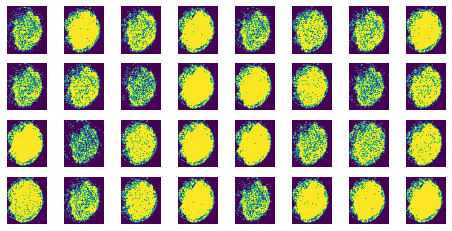

Epoch 151/500
Epoch 152/500
Epoch 153/500
Epoch 154/500
Epoch 155/500
Epoch 156/500
Epoch 157/500
Epoch 158/500
Epoch 159/500
Epoch 160/500
Epoch 161/500
Epoch 162/500
Epoch 163/500
Epoch 164/500
Epoch 165/500
Epoch 166/500
Epoch 167/500
Epoch 168/500
Epoch 169/500
Epoch 170/500
Epoch 171/500
Epoch 172/500
Epoch 173/500
Epoch 174/500
Epoch 175/500
Epoch 176/500
Epoch 177/500
Epoch 178/500
Epoch 179/500
Epoch 180/500
Epoch 181/500
Epoch 182/500
Epoch 183/500
Epoch 184/500
Epoch 185/500
Epoch 186/500
Epoch 187/500
Epoch 188/500
Epoch 189/500
Epoch 190/500
Epoch 191/500
Epoch 192/500
Epoch 193/500
Epoch 194/500
Epoch 195/500
Epoch 196/500
Epoch 197/500
Epoch 198/500
Epoch 199/500
Epoch 200/500


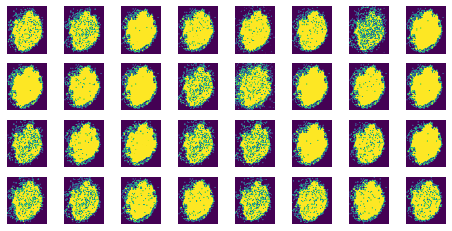

Epoch 201/500
Epoch 202/500
Epoch 203/500
Epoch 204/500
Epoch 205/500
Epoch 206/500
Epoch 207/500
Epoch 208/500
Epoch 209/500
Epoch 210/500
Epoch 211/500
Epoch 212/500
Epoch 213/500
Epoch 214/500
Epoch 215/500
Epoch 216/500
Epoch 217/500
Epoch 218/500
Epoch 219/500
Epoch 220/500
Epoch 221/500
Epoch 222/500
Epoch 223/500
Epoch 224/500
Epoch 225/500
Epoch 226/500
Epoch 227/500
Epoch 228/500
Epoch 229/500
Epoch 230/500
Epoch 231/500
Epoch 232/500
Epoch 233/500
Epoch 234/500
Epoch 235/500
Epoch 236/500
Epoch 237/500
Epoch 238/500
Epoch 239/500
Epoch 240/500
Epoch 241/500
Epoch 242/500
Epoch 243/500
Epoch 244/500
Epoch 245/500
Epoch 246/500
Epoch 247/500
Epoch 248/500
Epoch 249/500
Epoch 250/500


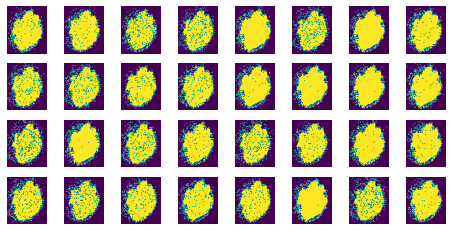

Epoch 251/500
Epoch 252/500
Epoch 253/500
Epoch 254/500
Epoch 255/500
Epoch 256/500
Epoch 257/500
Epoch 258/500
Epoch 259/500
Epoch 260/500
Epoch 261/500
Epoch 262/500
Epoch 263/500
Epoch 264/500
Epoch 265/500
Epoch 266/500
Epoch 267/500
Epoch 268/500
Epoch 269/500
Epoch 270/500
Epoch 271/500
Epoch 272/500
Epoch 273/500
Epoch 274/500
Epoch 275/500
Epoch 276/500
Epoch 277/500
Epoch 278/500
Epoch 279/500
Epoch 280/500
Epoch 281/500
Epoch 282/500
Epoch 283/500
Epoch 284/500
Epoch 285/500
Epoch 286/500
Epoch 287/500
Epoch 288/500
Epoch 289/500
Epoch 290/500
Epoch 291/500
Epoch 292/500
Epoch 293/500
Epoch 294/500
Epoch 295/500
Epoch 296/500
Epoch 297/500
Epoch 298/500
Epoch 299/500
Epoch 300/500


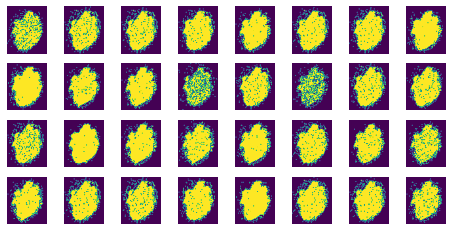

Epoch 301/500
Epoch 302/500
Epoch 303/500
Epoch 304/500
Epoch 305/500
Epoch 306/500
Epoch 307/500
Epoch 308/500
Epoch 309/500
Epoch 310/500
Epoch 311/500
Epoch 312/500
Epoch 313/500
Epoch 314/500
Epoch 315/500
Epoch 316/500
Epoch 317/500
Epoch 318/500
Epoch 319/500
Epoch 320/500
Epoch 321/500
Epoch 322/500
Epoch 323/500
Epoch 324/500
Epoch 325/500
Epoch 326/500
Epoch 327/500
Epoch 328/500
Epoch 329/500
Epoch 330/500
Epoch 331/500
Epoch 332/500
Epoch 333/500
Epoch 334/500
Epoch 335/500
Epoch 336/500
Epoch 337/500
Epoch 338/500
Epoch 339/500
Epoch 340/500
Epoch 341/500
Epoch 342/500
Epoch 343/500
Epoch 344/500
Epoch 345/500
Epoch 346/500
Epoch 347/500
Epoch 348/500
Epoch 349/500
Epoch 350/500


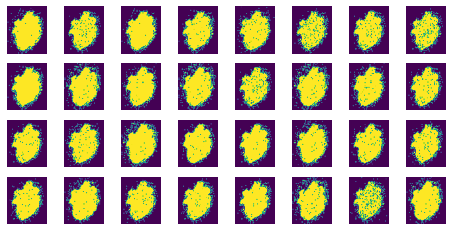

Epoch 351/500
Epoch 352/500
Epoch 353/500
Epoch 354/500
Epoch 355/500
Epoch 356/500
Epoch 357/500
Epoch 358/500
Epoch 359/500
Epoch 360/500
Epoch 361/500
Epoch 362/500
Epoch 363/500
Epoch 364/500
Epoch 365/500
Epoch 366/500
Epoch 367/500
Epoch 368/500
Epoch 369/500
Epoch 370/500
Epoch 371/500
Epoch 372/500
Epoch 373/500
Epoch 374/500
Epoch 375/500
Epoch 376/500
Epoch 377/500
Epoch 378/500
Epoch 379/500
Epoch 380/500
Epoch 381/500
Epoch 382/500
Epoch 383/500
Epoch 384/500
Epoch 385/500
Epoch 386/500
Epoch 387/500
Epoch 388/500
Epoch 389/500
Epoch 390/500
Epoch 391/500
Epoch 392/500
Epoch 393/500
Epoch 394/500
Epoch 395/500
Epoch 396/500
Epoch 397/500
Epoch 398/500
Epoch 399/500
Epoch 400/500


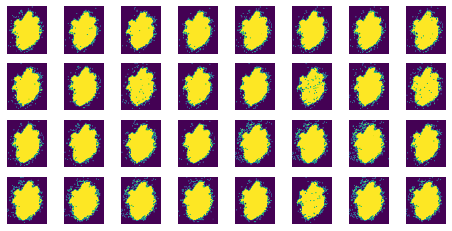

Epoch 401/500
Epoch 402/500
Epoch 403/500
Epoch 404/500
Epoch 405/500
Epoch 406/500
Epoch 407/500
Epoch 408/500
Epoch 409/500
Epoch 410/500
Epoch 411/500
Epoch 412/500
Epoch 413/500
Epoch 414/500
Epoch 415/500
Epoch 416/500
Epoch 417/500
Epoch 418/500
Epoch 419/500
Epoch 420/500
Epoch 421/500
Epoch 422/500
Epoch 423/500
Epoch 424/500
Epoch 425/500
Epoch 426/500
Epoch 427/500
Epoch 428/500
Epoch 429/500
Epoch 430/500
Epoch 431/500
Epoch 432/500
Epoch 433/500
Epoch 434/500
Epoch 435/500
Epoch 436/500
Epoch 437/500
Epoch 438/500
Epoch 439/500
Epoch 440/500
Epoch 441/500
Epoch 442/500
Epoch 443/500
Epoch 444/500
Epoch 445/500
Epoch 446/500
Epoch 447/500
Epoch 448/500
Epoch 449/500
Epoch 450/500


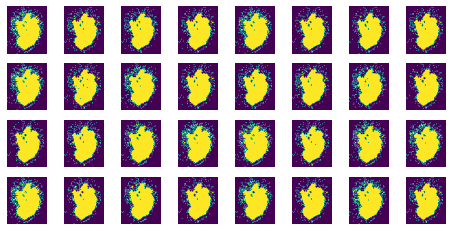

Epoch 451/500
Epoch 452/500
Epoch 453/500
Epoch 454/500
Epoch 455/500
Epoch 456/500
Epoch 457/500
Epoch 458/500
Epoch 459/500
Epoch 460/500
Epoch 461/500
Epoch 462/500
Epoch 463/500
Epoch 464/500
Epoch 465/500
Epoch 466/500
Epoch 467/500
Epoch 468/500
Epoch 469/500
Epoch 470/500
Epoch 471/500
Epoch 472/500
Epoch 473/500
Epoch 474/500
Epoch 475/500
Epoch 476/500
Epoch 477/500
Epoch 478/500
Epoch 479/500
Epoch 480/500
Epoch 481/500
Epoch 482/500
Epoch 483/500
Epoch 484/500
Epoch 485/500
Epoch 486/500
Epoch 487/500
Epoch 488/500
Epoch 489/500
Epoch 490/500
Epoch 491/500
Epoch 492/500
Epoch 493/500
Epoch 494/500
Epoch 495/500
Epoch 496/500
Epoch 497/500
Epoch 498/500
Epoch 499/500
Epoch 500/500


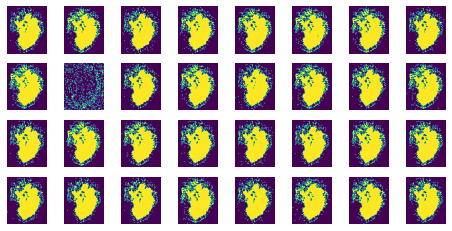

In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=500)

In [22]:
max(gen_loss_list)

81736.78

In [23]:
max(disc_loss_list)

50241948.0

In [ ]:
# Plotting the loss
plt.figure(figsize=(8,8))
plt.plot(np.array(gen_loss_list), label='gen-loss')
plt.plot(np.array(disc_loss_list), label='disc-loss', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 82736)
plt.legend()
plt.show()

In [27]:
# trying a different batch_size 
# real_size = 124
# batch_size = 248 - real_size
batch_size = 50
codings_size = 1000
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
GAN = generator(noise)

In [28]:
import numpy as np
import pickle
from pathlib import Path

path = Path('/project/ds6050-soa2wg/team_lambda_II/').expanduser()
path.mkdir(parents=True, exist_ok=True)

In [29]:
# using save (to npy), savez (to npz)
np.save(path/'4hr_gan_pos_male_ep500_cs3000_si{}'.format(batch_size), GAN)

## using loading npy, npz files
gan_loaded = np.load(path/'4hr_gan_pos_male_ep500_cs3000_si{}.npy'.format(batch_size))

In [30]:
gan_loaded.shape

(50, 61, 73, 61)

In [31]:
print(GAN == gan_loaded)

tf.Tensor(
[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   